In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.pipeline import Pipeline
#from xgboost import XGBRegressor

In [2]:
file_path = "case1Data.csv"
df = pd.read_csv(file_path)

In [ ]:
#Correlation
correlation_matrix = df.corr()
correlation_with_y = correlation_matrix["y"].abs().sort_values(ascending=False)

In [ ]:
#Select high correlated features
high_corr_features = correlation_with_y[correlation_with_y > 0.3].index.tolist()
high_corr_features.remove("y")

In [ ]:
# Imputer
df_high_corr = df[high_corr_features + ["y"]]
knn_imputer = KNNImputer(n_neighbors=5)
df_high_corr_imputed = pd.DataFrame(knn_imputer.fit_transform(df_high_corr), columns=df_high_corr.columns)
df.update(df_high_corr_imputed)

In [ ]:
X = df[high_corr_features]
y = df["y"]

#Standardlization
scaler = StandardScaler()

In [ ]:
# Models
models = {
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100)
}

# Cross Validation
for name, model in models.items():
    pipeline = Pipeline([("scaler", scaler), ("model", model)])
    scores = np.sqrt(-cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error'))
    print(f"{name} Mean RMSE: {scores.mean():.2f}, Std: {scores.std():.2f}")


Ridge Mean RMSE: 50.48, Std: 10.16
ElasticNet Mean RMSE: 49.73, Std: 12.24
XGBoost Mean RMSE: 56.18, Std: 5.09


In [ ]:
X_scaled = scaler.fit_transform(X)

In [ ]:
param_grid = {
    "alpha": np.logspace(-3, 3, 10),
    "l1_ratio": np.linspace(0.1, 0.9, 5)
}

In [ ]:
enet = ElasticNet(max_iter=5000)
grid_search = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=5000),
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='neg_mean_squared_error')

In [ ]:
best_enet = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]
best_l1_ratio = grid_search.best_params_["l1_ratio"]

In [ ]:
rmse_scores = np.sqrt(-cross_val_score(best_enet, X_scaled, y, cv=5, scoring='neg_mean_squared_error'))

In [ ]:
print(f"Best Alpha: {best_alpha}")
print(f"Best L1 Ratio: {best_l1_ratio}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Best Alpha: 2.154434690031882
Best L1 Ratio: 0.9
Mean RMSE: 47.19
Standard Deviation of RMSE: 11.12


# normalize data and using cv to find parameters as in w3_ex2

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import warnings # to silence convergence warnings
from sklearn.model_selection import train_test_split

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [4]:
def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [5]:
X = df.drop('y', axis=1)
y = df['y']

X_imputed_mean = X.fillna(X.mean())

# check if there are any columns with zero variance
variance = np.var(X_imputed_mean, axis=0)
zero_var_cols = np.where(variance == 0)[0]
print('Zero variance columns:', zero_var_cols)

# drop columns with zero variance
X_imputed_mean = X_imputed_mean.drop(X_imputed_mean.columns[zero_var_cols], axis=1)
print('Columns dropped:', X.columns[zero_var_cols])

[n, p] = np.shape(X_imputed_mean)

Zero variance columns: [96]
Columns dropped: Index(['C_02'], dtype='object')


average_rmse: [35.094136   33.80960412 32.92605751 33.38845457 35.09622147 37.9442093
 42.41606015 48.89111569 56.40299659 63.38079174 68.30954285 71.30717476
 72.29834152 72.34774597 72.34774597 72.34774597 72.34774597 72.34774597
 72.34774597 72.34774597]
best lambda for each fold: [0.00428133 0.00885867 0.001      0.00428133 0.0379269 ]
(20, 99) (20,) 9900


Text(0.5, 1.0, 'Sum of coefficients of Elastic Net Fit Alpha = 0.900')

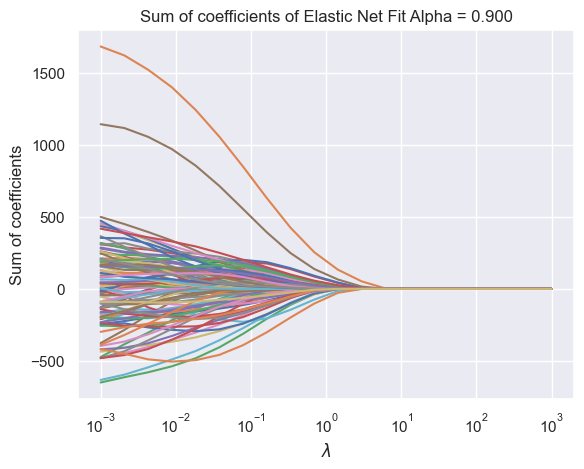

In [35]:
alpha = 0.9
lambdas = np.logspace(-3, 3, num=20)

CV = 5
kf = KFold(n_splits=CV)

coefs = np.zeros((CV,len(lambdas),p))
mse_fold = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    ytrain = y.iloc[train_index].values
    ytest = y.iloc[test_index].values
    Xtrain = X_imputed_mean.iloc[train_index].values
    Xtest = X_imputed_mean.iloc[test_index].values

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest-mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest-mu; # use the mean value of the training data to center the test data
    
    Xtrain,d = normalize(Xtrain) # normalize training data
    Xtest = Xtest / d # normalize test data using euclidian length of train data columns

    mse_lam = []
    for j, lambda_ in enumerate(lambdas):
        with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
            warnings.simplefilter("ignore")

            model = ElasticNet(l1_ratio = alpha, alpha=lambda_).fit(Xtrain, ytrain)
            coefs[i,j,:] = model.coef_
            mse_lam = np.append(mse_lam, np.mean((ytest - Xtest @ model.coef_)**2))
            
    mse_fold.append(mse_lam)

print("average_rmse:", np.sqrt(np.mean(mse_fold, axis=0)))
print("best lambda for each fold:", lambdas[np.argmin(mse_fold, axis=1)])
trace = np.sum(coefs, axis=0)
print(trace.shape,lambdas.shape,n*p)
plt.figure()
plt.semilogx(lambdas, trace)
plt.xlabel(r'$\lambda$')
plt.ylabel('Sum of coefficients')
plt.title('Sum of coefficients of Elastic Net Fit Alpha = %.3f' % alpha)


In [38]:
best_lambda = np.mean(lambdas[np.argmin(mse_fold, axis=1)])

Xtrain, Xtest, ytrain, ytest = train_test_split(X_imputed_mean, y, test_size=0.2)

Xtrain, mu = centerData(Xtrain)
Xtest = Xtest - mu

Xtrain, d = normalize(Xtrain)
Xtest = Xtest / d

ytrain, mu = centerData(ytrain)
ytest = ytest - mu

model = ElasticNet(l1_ratio = alpha, alpha=best_lambda).fit(Xtrain, ytrain)
rmse = np.sqrt(np.mean((ytest - Xtest @ model.coef_)**2))
print('RMSE:', rmse)

RMSE: 32.25020123044408
